# Agent Testing Notebook

This notebook is for testing the `LangGraphAgent` with different agent architectures.

## Setup

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os
from dotenv import load_dotenv
load_dotenv()
from typing import Any, Callable, List, Optional, cast, Dict, Literal, Union
from pydantic import BaseModel, Field, field_validator
from langchain.tools import BaseTool, tool
from langchain_core.language_models import BaseChatModel
from src.langgraph.app.core.langgraph.deepagents import DeepResearchAgent 
from src.langgraph.app.core.langgraph.smolagent import SMOLAgent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
import asyncio
import os
import logging
from typing import List, Sequence, TypedDict, Annotated, Optional, Dict, Any

from dotenv import load_dotenv
from langchain_core.language_models.base import BaseLanguageModel
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.base import BaseCheckpointSaver
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langgraph.managed import RemainingSteps

# Local application imports
from src.langgraph.app.core.langgraph.agents import create_agent
from src.langgraph.app.core.langgraph.smolagent import SMOLAgent
# from src.langgraph.app.core.langgraph.toolsagent import ToolsAgent
from src.langgraph.app.core.langgraph.deepagents import DeepResearchAgent
from src.langgraph.app.core.langgraph.swarm import SwarmState, create_handoff_tool, create_swarm


llm = ChatOpenAI(model="gpt-4.1", temperature=0)
selector_llm = ChatOpenAI(model="gpt-4.1", temperature=0)

memory = MemorySaver()

In [1]:
import copy

## 1. Base Agent Test

In [7]:

from src.langgraph.app.core.langgraph import MORGANA

agent = MORGANA(
    llm=llm,
    checkpointer=memory
)
my_agent = await agent.build()


MORGANA swarm factory initialized.
Building and compiling the agent swarm executor...
SMOLAgent factory initialized.
Building and compiling the agent executor...
Building and compiling the agent swarm executor...
SMOLAgent factory initialized.
Building and compiling the agent executor...
Agent executor compiled successfully.
DeepResearchAgent factory initialized.
Building the deep research agent executor...
Agent executor compiled successfully.
DeepResearchAgent factory initialized.
Building the deep research agent executor...
Deep research agent executor built successfully.
ToolsAgent factory initialized.
Building and compiling the ToolsAgent executor...
Initializing tools from local files and dedicated MCP server...
MICROSOFT_MCP_SERVER_URL not set. Proceeding with local tools only.
Total tools available: 14. Names: ['tavily_web_search', 'Weather Search', 'send_whatsapp_voice_message', 'send_whatsapp_message', 'google_flight_tool', 'google_flight_search', 'booking_tool', 'google_plac

Starting new HTTPS connection (1): mermaid.ink:443
https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCVNtb2xfQWdlbnQoU21vbF9BZ2VudCkKCURlZXBfUmVzZWFyY2hfQWdlbnQoRGVlcF9SZXNlYXJjaF9BZ2VudCkKCVRvb2xzX0FnZW50KFRvb2xzX0FnZW50KQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCURlZXBfUmVzZWFyY2hfQWdlbnQgLS4tPiBTbW9sX0FnZW50OwoJRGVlcF9SZXNlYXJjaF9BZ2VudCAtLi0+IFRvb2xzX0FnZW50OwoJX19zdGFydF9fIC0uLT4gRGVlcF9SZXNlYXJjaF9BZ2VudDsKCV9fc3RhcnRfXyAtLi0+IFNtb2xfQWdlbnQ7CglfX3N0YXJ0X18gLS4tPiBUb29sc19BZ2VudDsKCVNtb2xfQWdlbnQgLS0+IF9fZW5kX187CglUb29sc19BZ2VudCAtLT4gX19lbmRfXzsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 17713
https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19z

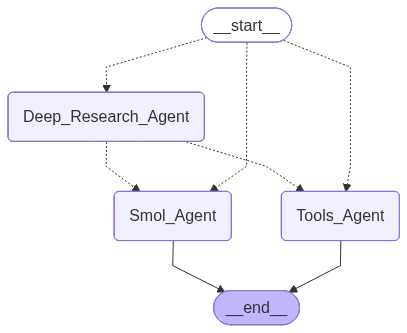

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        my_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [10]:

# 4. Define the research task and run the agent
thread_config = {"configurable": {"thread_id": "deep-research-thread-111221"}}
query = "What's the current weather in Norman, Oklahoma? Based on that, find a highly-rated coffee shop nearby."

initial_input = {"messages": [HumanMessage(content=query)]}

print(f"--- Running Deep Research Agent for query: '{query}' ---")

# The .invoke() method is synchronous and works here because my_agent is now correctly instantiated.
# Note: Your main() example used astream_events for streaming, which is also a great option.
result = my_agent.invoke(initial_input, config=thread_config)

# The final output structure might vary, adjust this key if needed.
if result.get('messages') and isinstance(result['messages'], list) and len(result['messages']) > 1:
        final_report_content = result['messages'][-1].content
        # Assuming the report is in the content of the last message
        print("\n--- FINAL REPORT ---")
        print(final_report_content)
else:
        print("Could not find final report in the result.")
        print(result)




--- Running Deep Research Agent for query: 'What's the current weather in Norman, Oklahoma? Based on that, find a highly-rated coffee shop nearby.' ---

Request options: {'method': 'post', 'url': '/chat/completions', 'headers': {'X-Stainless-Raw-Response': 'true'}, 'files': None, 'idempotency_key': 'stainless-python-retry-5ababf4b-ad95-405c-a1a0-2d027517f1f0', 'json_data': {'messages': [{'content': "You are a highly intelligent AI agent designed to assist users by leveraging a variety of tools and resources. Your primary goal is to understand the user's needs and provide accurate, relevant, and timely information or actions based on the tools at your disposal.\nYou have access to the following tools:\n\n", 'role': 'system'}, {'content': "What's the current weather in Norman, Oklahoma? Based on that, find a highly-rated coffee shop nearby.", 'role': 'user'}], 'model': 'gpt-4.1', 'stream': False, 'temperature': 0.0, 'tools': [{'type': 'function', 'function': {'name': 'transfer_to_deep_re

In [11]:
result

{'messages': [HumanMessage(content="What's the current weather in Norman, Oklahoma? Based on that, find a highly-rated coffee shop nearby.", additional_kwargs={}, response_metadata={}, id='b1b37a4b-a6fc-4b38-b00a-3d9f38abb1bd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qxuCYZs7NANTGNkNngdxbs4t', 'function': {'arguments': '{"task":"Get the current weather in Norman, Oklahoma and find a highly-rated coffee shop nearby based on the weather."}', 'name': 'transfer_to_tools_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 383, 'total_tokens': 419, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_daf5fcc80a', 'id': 'chatcmpl-CEmXgKXjNC6lGQ2Tn1SHAGhtMy5Qg', 'service_tier': 

In [22]:
import nest_asyncio

# Streaming agent output using LangGraph's recommended "messages" mode
print(f"--- Streaming Deep Research Agent for query: '{query}' ---")

async def stream_agent_messages():
    # Use "messages" mode for token-by-token streaming
    async for chunk, metadata in my_agent.astream(initial_input, config=thread_config, stream_mode="messages"):
        # Print only non-empty tokens
        if hasattr(chunk, "content") and chunk.content:
            print(chunk.content, end="", flush=True)

nest_asyncio.apply()
await stream_agent_messages()

--- Streaming Deep Research Agent for query: 'can you check the weather in Oklahoma and then find the nearest coffee shop in Norman and where to party.' ---

Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'idempotency_key': 'stainless-python-retry-baf3ba01-fc33-495c-b717-13b15e77b745', 'json_data': {'messages': [{'content': "You are a highly intelligent AI agent designed to assist users by leveraging a variety of tools and resources. Your primary goal is to understand the user's needs and provide accurate, relevant, and timely information or actions based on the tools at your disposal.\nYou have access to the following tools:\n\n", 'role': 'system'}, {'content': 'can you check the weather in Oklahoma and then find the nearest coffee shop in Norman and where to party.', 'role': 'user'}, {'content': None, 'role': 'assistant', 'tool_calls': [{'type': 'function', 'id': 'call_JBcnSi0GIxlAUsFW0TG8gAzi', 'function': {'name': 'transfer_to_tools_agent', 'argument

## 2. Testing LangraphAgent class

In [2]:
from src.langgraph.app.core.langgraph import LangGraphAgent, MORGANA
import uuid
from src.langgraph.app.schemas import (
    GraphState,
    Message,
)
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [12]:
# This is a common pattern for testing code with global dependencies.

# ==============================================================================
# >> STEP 2: DEFINE THE ASYNCHRONOUS TEST RUNNER
# ==============================================================================

async def run_agent_tests():
    """
    An asynchronous function to instantiate and test all
    methods of the LangGraphAgent class.
    """
    print("\n--- 2. INSTANTIATING LANGGRAPH AGENT ---")
    agent = LangGraphAgent()
    
    # Generate a unique session ID for this test run to keep the conversation isolated
    session_id = f"test-session-{uuid.uuid4()}"
    user_id = "test-user-1234"
    print(f"Using Session ID: {session_id}")
    
    # --------------------------------------------------------------------------
    # >> TEST 1: Get Response (Non-Streaming)
    # --------------------------------------------------------------------------
    print("\n--- 3. TESTING get_response (NON-STREAMING) ---")
    
    # This is a complex query perfect for a multi-agent system
    query1 = "What's the current weather in Norman, Oklahoma? Based on that, find a highly-rated coffee shop nearby."
    
    messages = [Message(role="user", content=query1)]

    try:
        response = await agent.get_response(messages, session_id, user_id)
        print("\n[SUCCESS] Agent's Final Response:")
        # The response is a list of dictionaries, we'll print the last one
        if response:
            print(response[-1]['content'])
        else:
            print("Agent returned an empty response.")
    except Exception as e:
        print(f"\n[FAILURE] An error occurred during get_response: {e}")


    # --------------------------------------------------------------------------
    # >> TEST 2: Get Stream Response (Streaming)
    # --------------------------------------------------------------------------
    print("\n--- 4. TESTING get_stream_response (STREAMING) ---")
    
    # Continue the conversation in the same session
    query2 = "Great. Now, where's a good place to go out tonight?"
    
    # The 'messages' list should include the history for context
    messages.append(Message(role="assistant", content="...")) # Placeholder for previous AI response
    messages.append(Message(role="user", content=query2))
    
    print("\n[SUCCESS] Agent's Streaming Response:")
    full_streamed_response = ""
    try:
        async for token in agent.get_stream_response(messages, session_id, user_id):
            print(token, end="", flush=True)
            full_streamed_response += token
        print("\n--- End of Stream ---")
    except Exception as e:
        print(f"\n[FAILURE] An error occurred during get_stream_response: {e}")

    # --------------------------------------------------------------------------
    # >> TEST 3: Get Chat History
    # --------------------------------------------------------------------------
    print("\n--- 5. TESTING get_chat_history ---")
    print("Fetching history to verify the conversation was saved by the checkpointer...")
    
    try:
        history = await agent.get_chat_history(session_id)
        if history:
            print("\n[SUCCESS] Retrieved Chat History:")
            for msg in history:
                print(f"- {msg.role.capitalize()}: {msg.content[:100]}...") # Print first 100 chars
            assert len(history) > 1, "History should contain more than one message."
        else:
            print("\n[WARNING] Chat history is empty. The checkpointer might not be configured correctly.")
    except Exception as e:
        print(f"\n[FAILURE] An error occurred during get_chat_history: {e}")
        
    # --------------------------------------------------------------------------
    # >> TEST 4: Clear Chat History
    # --------------------------------------------------------------------------
    print("\n--- 6. TESTING clear_chat_history ---")
    
    try:
        await agent.clear_chat_history(session_id)
        print(f"\n[SUCCESS] Called clear_chat_history for session {session_id}.")
        
        # Verification step: Try to fetch the history again
        print("Verifying history deletion by fetching it again...")
        cleared_history = await agent.get_chat_history(session_id)
        
        if not cleared_history:
            print("[SUCCESS] Verification complete. Chat history is now empty.")
        else:
            print("[FAILURE] Verification failed. History was not cleared.")
            print("Remaining history:", cleared_history)
            
    except Exception as e:
        print(f"\n[FAILURE] An error occurred during clear_chat_history: {e}")



In [13]:
# ==============================================================================
if __name__ == "__main__":
    # In a Jupyter notebook, you might need to use this if you encounter
    # a "RuntimeError: This event loop is already running"
    # import nest_asyncio
    # nest_asyncio.apply()
    
    print("==============================================")
    print("  STARTING LANGGRAPH AGENT TEST SUITE")
    print("==============================================")
    
    asyncio.run(run_agent_tests())

    print("\n==============================================")
    print("  TEST SUITE COMPLETE")
    print("==============================================")

  STARTING LANGGRAPH AGENT TEST SUITE

--- 2. INSTANTIATING LANGGRAPH AGENT ---

  STARTING LANGGRAPH AGENT TEST SUITE

--- 2. INSTANTIATING LANGGRAPH AGENT ---
2025-09-12T01:08:32.916463Z [info     ] llm_initialized_for_morgana    [src.langgraph.app.core.logging] environment=development filename=graph.py func_name=__init__ lineno=2025-09-12T01:08:32.916463Z [info     ] llm_initialized_for_morgana    [src.langgraph.app.core.logging] environment=development filename=graph.py func_name=__init__ lineno=70 model=70 model=gpt-4o-mini module=graph pathname='c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\morgana\\backend\\src\\langgraph\\app\\core\\langgraph\\graph.py'
Using Session ID: test-session-212734ec-6581-4543-8542-12a77ef005c3

--- 3. TESTING get_response (NON-STREAMING) ---
2025-09-12T01:08:32.942796Z [gpt-4o-mini module=graph pathname='c:\\Users\\pault\\Documents\\3. AI and Machine Learning\\2. Deep Learning\\1c. App\\Projects\\morgana